# Mobile Robotics Project - Controlling Thymio
The following report details how the Thymio robot was controlled through an obstacle filled course with sudden local obstacles added. A camera was implemented to create a map and track the position and orientation of the robot. These variables were then processed through a Kalman Filter combining odometry to output the necessary variables for a PID controller to direct the mobile robot. 

In [4]:
!pip install tqdm scipy

In [1]:
#The exclamation point (!) allow to execute a terminal command in the notebook:
!python -m tdmclient list

id:         897f4316-849f-452b-8c0a-a842ee0e03d1
group id:   6193fec4-048a-4150-98b6-0c511867b962
product id: 8 (Thymio II)
name:       USB Serial Device
status:     2 (available)
cap:        7
firmware:   14



In [2]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 897f4316-849f-452b-8c0a-a842ee0e03d1

## 1. Vision Processing
The vision system takes the images captured by the camera and locates the robot, obstacles, goal and start position.

## 2. Global Navigation
The A* algorithm was selected to create the ideal path for the robot to travel. The code for this algorithm was obtained from the solutions from the week 5 and modified to adapt the project specifications. 

Path found:
[(8, 5), (7, 4), (7, 3), (6, 2), (5, 1), (4, 1), (3, 1), (2, 2), (1, 2), (0, 2), (0, 1), (0, 0)]
Number of operations: 53


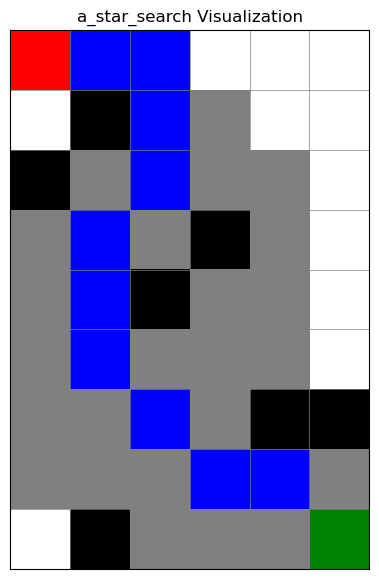

In [8]:
# Code from exercises week 5, modified A* algorithm, BoMR course

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from heapq import heappush, heappop # used if you want to use heap queue for priority queue (easier to implement) but not compulsory

def heuristic(a, b):
    # Implement the Euclidean distance heuristic
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def in_grid(grid, pos):
    return 0 <= pos[0] < grid.shape[0] and 0 <= pos[1] < grid.shape[1]

def is_obstacle(grid, pos):
    return not in_grid(grid, pos) or (grid[pos] == -1)

async def a_star_search(map_grid, start, goal):
    # Initialize the open set as a priority queue and add the start node
    open_set = []
    heappush(open_set, (heuristic(start, goal), 0, start))  # (f_cost, g_cost, position)

    # Initialize the came_from dictionary
    came_from = {}
    # Initialize g_costs dictionary with default value of infinity and set g_costs[start] = 0
    g_costs = {start: 0}
    # Initialize the explored set
    explored = set()
    operation_count = 0

    while open_set:
        # Pop the node with the lowest f_cost from the open set
        current_f_cost, current_g_cost, current_pos = heappop(open_set)

        # Add the current node to the explored set
        explored.add(current_pos)

        # For directly reconstruct path
        if current_pos == goal:
            break
        
        up         = (current_pos[0] - 1, current_pos[1]    )
        down       = (current_pos[0] + 1, current_pos[1]    )  # Down
        left       = (current_pos[0]    , current_pos[1] - 1)  # Left
        right      = (current_pos[0]    , current_pos[1] + 1)  # Right
        up_left    = (current_pos[0] - 1, current_pos[1] - 1)  # Up Left
        down_right = (current_pos[0] + 1, current_pos[1] + 1)  # Down Right
        down_left  = (current_pos[0] + 1, current_pos[1] - 1)  # Down Left
        up_right   = (current_pos[0] - 1, current_pos[1] + 1)   # Up Right
        # Get the neighbors of the current node (up, down, left, right)
        neighbors = [up, down, left, right, up_left, down_right, down_left, up_right]
        
        
        if is_obstacle(map_grid, up) or is_obstacle(map_grid, left) :
                neighbors.remove(up_left)
        
        if is_obstacle(map_grid, up) or is_obstacle(map_grid, right):
                neighbors.remove(up_right)
                
        if is_obstacle(map_grid, down) or is_obstacle(map_grid, right):
                neighbors.remove(down_right)
                
        if is_obstacle(map_grid, down) or is_obstacle(map_grid, left):
                neighbors.remove(down_left)
            
                
        for neighbor in neighbors:
            # Check if neighbor is within bounds and not an obstacle
            if (in_grid(map_grid,neighbor)) and map_grid[neighbor[0], neighbor[1]] != -1 and neighbor not in explored:
                # Calculate tentative_g_cost
                tentative_g_cost = current_g_cost + heuristic(current_pos, neighbor)
                
                # If this path to neighbor is better than any previous one
                if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                    # Update came_from, g_costs, and f_cost
                    came_from[neighbor] = current_pos
                    g_costs[neighbor] = tentative_g_cost
                    f_cost = tentative_g_cost + heuristic(neighbor, goal)

                    # Add neighbor to open set
                    heappush(open_set, (f_cost, tentative_g_cost, neighbor))
                    operation_count += 1

    # Reconstruct path
    if current_pos == goal:
        path = []
        while current_pos in came_from:
            path.append(current_pos)
            current_pos = came_from[current_pos]
        path.append(start)
        return path[::-1], explored,operation_count
    else:
        # If we reach here, no path was found
        return None, explored,operation_count
    
    
##############################################
#do not modify this code
##############################################
def display_map(map_grid, path, start, goal, explored):
    cmap = ListedColormap(['white', 'black', 'blue', 'green', 'red', 'grey'])
    map_display = np.zeros_like(map_grid, dtype=object)

    # Assign colors based on the map grid values
    map_display[map_grid == -1] = 'black'  # Obstacles
    map_display[map_grid == 0] = 'white'   # Free space

    for position in explored:
        if map_display[tuple(position)] == 'white':
            map_display[tuple(position)] = 'grey'  # Explored cells

    # Visualize the path
    for position in path:
        if map_display[position[0], position[1]] in ['white', 'grey']:
            map_display[position[0], position[1]] = 'blue'  # Path

    map_display[start[0], start[1]] = 'green'  # Start
    map_display[goal[0], goal[1]] = 'red'      # Goal

    # Convert color names to numbers for plotting
    color_mapping = {'white': 0, 'black': 1, 'blue': 2, 'green': 3, 'red': 4, 'grey': 5, 'yellow': 6}
    map_numeric_display = np.vectorize(color_mapping.get)(map_display)
    fig, ax = plt.subplots(figsize=(6, 7))
    ax.imshow(map_numeric_display, cmap=cmap)
    ax.set_xticks(np.arange(-0.5, map_grid.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, map_grid.shape[0], 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    ax.set_title('a_star_search Visualization')
    plt.show()

map_height = 9
map_width = 6
Map = np.zeros((map_height, map_width))



Map[8, 1] = -1; Map[6, 4:6] = -1; Map[4, 2:3] = -1; Map[3, 3] = -1; Map[1, 1] = -1; Map[2, 0] = -1

SearchStart =  (8, 5)
SearchGoal  =  (0, 0)

path, explored, operation_count = await a_star_search(Map, SearchStart, SearchGoal)

# Display the result
if path:
    print("Path found:")
    print(path)
    print(f"Number of operations: {operation_count}")
    display_map(Map, path, SearchStart, SearchGoal, explored)
else:
    print("No path found.")

With the most efficient path stored, the critical points, meaning changes in orientation, were stored in a new list that defined the goals for the controller. This list is produced by the following function. 

In [10]:
# Takes the path created by the A* algorithm as an argument and removes the points with a repeated orientation

async def goal_list_from_path(path):
    goal_list = path.copy()
    popped = 0
    for i in range(len(path)-2):
        # Checks if three consecutive points lie in a straiExght line and removes middle because it is redundant
        if (path[i+1][0] - path[i][0] == path[i+2][0] - path[i+1][0]) and (path[i+1][1] - path[i][1] == path[i+2][1] - path[i+1][1]):
            goal_list.pop(i+1 - popped)
            popped += 1
    return goal_list

goal_list = await goal_list_from_path(path)

print("A* path:           ", path)
print("Reduced goal list: ", goal_list)

A* path:            [(8, 5), (7, 4), (7, 3), (6, 2), (5, 1), (4, 1), (3, 1), (2, 2), (1, 2), (0, 2), (0, 1), (0, 0)]
Reduced goal list:  [(8, 5), (7, 4), (7, 3), (5, 1), (3, 1), (2, 2), (0, 2), (0, 0)]


## 3. Local Navigation
The local navigation relies on the horizontal sensors of the Thymio. If an object is detected, the robot changes the velocity of the motors to effectively avoid it. The motor velocity changes are made through the **weights**. Each weight determines how a sensor impacts the robots movement which is why the weights for each motor (output) are symmetric, but opposite in sign. In this way, when a sensor detects an obstacle the motors respond in a way that steer it away. 

The code can be seen as a single-layer neural network where the input is the proximity sensor (9 elements) and the output is each motor (2). Parts of the code were taken from the solutions to the third week exercises on Artificial Neural Networks. 

In [12]:
## For testing functionality of the sensors

# Function was obtained from the solutions of the week 3 exercises covering artificial neural networks
async def print_sensor_values(sensor_id, print_range=2, delta_time=0.2):
    """
    Print the sensor value sensor_id print_range times, every delta_time seconds
    """
    await node.wait_for_variables({str(sensor_id)})
    for i in range(print_range):
        print(list(node[sensor_id]))
        await client.sleep(delta_time)
        
await print_sensor_values('prox.horizontal')

[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]


In [13]:
## Function to obtain the sensor values from the selected type of sensors. Similar to function print_sensor_values obtained from solutions for week 3 exercises

async def get_sensor_values(sensor_id, delay=0.01):
    await client.sleep(delay)
    sensor_values = list(node[sensor_id])  # Retrieve the current values
    return sensor_values  # Return the collected sensor values as a list

horizontal_sensor_values = await get_sensor_values('prox.horizontal')

In [14]:
## Function to verify if there are any obstacles. Gets the current readings of the get_sensor_values function for the horizontal sensors
## If the value of the sensor is above the proximity threshold, it sends a 1

async def check_obstacles(proximity_threshold=2000):
    horizontal_sensor_values = await get_sensor_values('prox.horizontal')
    if any(x > proximity_threshold for x in horizontal_sensor_values):
        return 1  # Obstacle detected
    return 0  # No obstacle

In [15]:
## Function to avoid obstacles based on neural network
## Obtained from solutions for week 3 exercises and adapted to satisfy speed requirements and asynchronous functionality

async def obstacle_avoidance(left_output=0, right_output=0):
    # Define weights for left and right motors
    w_l = [40, 20, -20, -20, -40, 30, -10]
    w_r = [-40, -20, -20, 20, 40, -10, 30]

    # Scale factors for sensors and constant factor
    sensor_scale = 500
    
    # Read proximity sensor values
    prox_values = list(node['prox.horizontal'])
    
    # Compute motor outputs based on the scaled sensor values
    for i in range(len(prox_values)):
        # Scale the sensor readings
        scaled_value = prox_values[i] // sensor_scale
        
        # Update outputs for left and right motors
        left_output += scaled_value * w_l[i] // 3
        right_output += scaled_value * w_r[i] // 3

    # Set motor powers
    await node.set_variables(motors(left_output, right_output))
    print(f"Left Motor: {left_output}, Right Motor: {right_output}")
    
    return left_output, right_output

## 4. Kalman Filter

## 5. Motion Control

### 5.1 PID Control

To effectively create a controller to ensure the robot was able to follow the path, a PID controller based on the orientation error of the robot was employed. The orientation is obtained through the camera and processed with the Kalman filter to effectively control the robot. A series of functions were used to create the controller based on the error measured between the desired path and the actual measurements. The appropriate gains were selected after testing their effect and identifying the desired response for the robot. The following considerations were taken into account:

#### Proportional Gain (\(k_p\))
- Controls the strength of the robot's response to the current error.
- Determines the time taken to correct the error (avoiding overshooting or overly slow responses).

#### Integral Gain (\(k_i\))
- Controls the accumulation of errors in the past through an integration operation.
- Ensures there are no steady-state errors by compensating for persistent offsets.

#### Derivative Gain (\(k_d\))
- Controls the robot's reaction to the rate of change of the error.
- Determines the sensitivity of the controller, ensuring the correction rate is neither too aggressive nor too delayed.

To test the controller, a simulator was employed, and the correseponding codes a
 also included.


The following function takes as input the desired x and y positions as well as the current positions to get the errors. This will be used in the PID controller. For position, the Euclidean distance norm is used: 
\begin{equation} 
dist error = \sqrt{x_{err}^2 + y_{err}^2} 
\end{equation}

For orientation, the following equation is used:
\begin{equation} 
\phi_d = \arctan2(y_{\text{err}}, x_{\text{err}}) 
\end{equation} 
\begin{equation} 
\phi_{\text{err}} = \phi_d - \phi 
\end{equation}

The orientation error is then normalized to the range -180° to 180°. 

In [20]:
## This function calculates the position and orientation errors based on the estimated and desired positions of the robot
# from https://felipenmartins.github.io/Robotics-Simulation-Labs/Lab4/
import numpy as np

async def get_pose_error(xd, yd, x, y, phi):
    """ Returns the position and orientation errors. 
        Orientation error is bounded between -pi and +pi radians.
    """
    # Position error:
    x_err = xd - x
    y_err = yd - y
    dist_err = np.sqrt(x_err**2 + y_err**2) # Euclidean distance

    # Orientation error
    phi_d = np.arctan2(y_err,x_err)
    phi_err = phi_d - phi

    # Limits the error to (-pi, pi):
    phi_err_correct = np.arctan2(np.sin(phi_err),np.cos(phi_err))

    return dist_err, phi_err_correct

This definition defines a PID controller defining the gains for each of the terms. It takes as input the current error, the error from the previous step, the accumulated error and the time step and applies the following equation. The Gains can be declared as a result of trial and error. The PID function is composed of the following:
\begin{equation} P = k_p \cdot e \end{equation}
\begin{equation} I = e_{\text{acc}} + k_i \cdot e \cdot \Delta t \end{equation}
\begin{equation} D = k_d \cdot \frac{e - e_{\text{prev}}}{\Delta t} \end{equation}
\begin{equation}
\text{Output} = k_p \cdot e + k_i \cdot \int e \, dt + k_d \cdot \frac{de}{dt}
\end{equation}

In [22]:
## This function implements a "goal to goal" behavior meaning that it controls the robot orientation by adjusting the angular speed
# from https://felipenmartins.github.io/Robotics-Simulation-Labs/Lab4/

async def pid_controller(e, e_prev, e_acc, delta_t, kp=1.0, kd=0, ki=0):
    """ 
    PID algortithm: must be executed every delta_t seconds
    The error e must be calculated as: e = desired_value - actual_value
    e_prev contains the error calculated in the previous step.
    e_acc contains the integration (accumulation) term.
    """
    P = kp*e                      # Proportional term; kp is the proportional gain
    I = e_acc + ki*e*delta_t      # Intergral term; ki is the integral gain
    D = kd*(e - e_prev)/delta_t   # Derivative term; kd is the derivative gain

    output = P + I + D              # controller output, angular velocity in this case

    # store values for the next iteration
    e_prev = e     # error value in the previous interation (to calculate the derivative term)
    e_acc = I      # accumulated error value (to calculate the integral term)

    return output, e_prev, e_acc

Taking the output of the PID controller (angular speed), the speed for each wheel is calculated with the following equations. The linear speed remains constant to avoid complex behaviors and inaccurate position estimation. 
\begin{equation} w_{r_d} = \frac{2u_d - dw_d}{2r} \end{equation} 
\begin{equation} w_{l_d} = \frac{2u_d + dw_d}{2r} \end{equation}

In [24]:
## This function calculates the speeds for the left and right wheels based on the desired values of linear and angular speeds
# from https://felipenmartins.github.io/Robotics-Simulation-Labs/Lab4/

async def wheel_speed_commands(u_d, w_d, d, r):
    """
    Convert desired robot speeds to desired wheel speeds
    """
    wr_d = float((2 * u_d - d * w_d) / (2 * r))
    wl_d = float((2 * u_d + d * w_d) / (2 * r))
    
    # If saturated, correct speeds to keep the original turning ratio
    #if np.abs(wl_d) > MAX_SPEED or np.abs(wr_d) > MAX_SPEED:
     #   speed_ratio = np.abs(wr_d)/np.abs(wl_d)
      #  if speed_ratio > 1:
       #     wr_d = np.sign(wr_d)*MAX_SPEED
        #    wl_d = np.sign(wl_d)*MAX_SPEED/speed_ratio
        #else:
         #   wl_d = np.sign(wl_d)*MAX_SPEED
          #  wr_d = np.sign(wr_d)*MAX_SPEED*speed_ratio
        
    return wl_d, wr_d

Based on the speeds of the wheels, the function updates the robot's position virtually. 

\begin{equation} \text{Forward Speed} = \frac{r \cdot (w_r + w_l)}{2} \end{equation} 
\begin{equation} \text{Angular Speed} = \frac{r \cdot (w_l - w_r)}{d} \end{equation}

\begin{equation} x = \text{Forward Speed} \cdot \cos(\phi) \cdot \Delta t + x_{prev} \end{equation} 
\begin{equation} y = \text{Forward Speed} \cdot \sin(\phi) \cdot \Delta t + y_{prev} \end{equation}

\begin{equation} \phi = \text{Angular Speed} \cdot \Delta t + phi_{prev} \end{equation} 
\begin{equation} \phi = \arctan2(\sin(\phi), \cos(\phi)) \end{equation}

In [26]:
async def update_odometry(x, y, phi, wl, wr, d, r, delta_t):
    # Update robot's position and orientation using odometry
    forward_speed = (wr + wl) * r / 2
    angular_speed = (wl - wr) * r / d

    x += forward_speed * np.cos(phi) * delta_t / 14
    y += forward_speed * np.sin(phi) * delta_t / 14
    phi += angular_speed * delta_t

    # Keep phi within (-pi, pi)
    phi = np.arctan2(np.sin(phi), np.cos(phi))

    return x, y, phi

In [27]:
async def check_kidnapping():
    # Get the current ground sensor values
    ground_sensor_values = await get_sensor_values('prox.ground.reflected')

    # Debugging print to observe sensor values
    #print(f"Ground Sensor Values: {ground_sensor_values}")

    # Threshold to detect lifting
    ground_threshold = 25  

    # Check if both ground sensors are below the threshold
    if ground_sensor_values[1] < ground_threshold and ground_sensor_values[0] < ground_threshold:
        print("Kidnapping detected! Robot lifted off the ground. Check_kidnapping function")
        return 1  # Return 1 for kidnapping state
    else:
        return 0  # Normal operation

### 5.2 Main Control Loop combining the global and local navigation


The main control loop is the bases of the robot's navigation system allowing the robot to follow the global path created with A* while continuously checking for obstacles and adjusting its movement using odometry and PID control. The loop operates as follows:

1. **Path Following**: The robot navigates in the key points (turning points in the A*) in the goal list, moving from one goal to the next.
2. **Obstacle Detection**: The robot checks for nearby obstacles using proximity sensors. If an obstacle is detected, it triggers an obstacle avoidance routine.
3. **Pose Error Calculation**: The robot calculates the error considering the next point and the current robot orientation.
4. **PID Controller**: A PID controller processes the orientation error to compute an angular speed command, ensuring smooth and accurate movements. Given that the Thymio actuators are not precise, this controller helps ensure the accurate path is taken. Similarly, when a local obstacle is detected, the PID controller ensures the path is retaken.
5. **Wheel Speed Commands**: The desired forward and angular speeds are converted into individual wheel speeds for the robot's motors.
6. **Odometry Updates**: The robot's position and orientation are updated in real time using odometry, based on the wheel movements.
7. **Goal Reached Check**: If the robot reaches a goal within a predefined tolerance, it advances to the next goal.

#### State Machine Archtecture
The overall structure of the main control loop is based on a state machine. 
- **State 0: Path Following**
The robot follows the predefined path (A*) with the PID control.
- **State 1: Obstacle Avoidance** 
Obstacle avoidance procedure based on Neural Networks.
- **State 2: Path Recalculation** 
Creates a new grid and recomputes the ideal path.

In [31]:
## Function from exercises week 8, BoMR course

def motors(left, right):
    return {
        "motor.left.target": [left],
        "motor.right.target": [right],
    }

In [32]:
## For testing functionality of the motor (signal reception)
node.send_set_variables(motors(100, 100))

In [35]:
## For testing functionality
node.send_set_variables(motors(0, 0))

The main control loop defines several initial values which were established based on testing results. 

In [107]:
import time

async def main_control_loop(goal_list):
    """
    Main control loop structured as a finite state machine.
    """
    # Starting state
    state = 10
    
    # Constant forward speed
    u_const = 4  # cm/s (adjust based on your robot's speed capabilities)

    # Robot geometric parameters
    base_width = 9.4   # cm
    wheel_radius = 2.2 # cm

    # Speed constant (convert thymio motor speed to forward speed)
    speed_constant = 0.033615 # cm/s

    # Time step
    delta_t = 0.2  # seconds

    # Initial errors for PID
    phi_err_prev = 0
    phi_err_acc = 0

    # Signal to finish running the code indefinetely
    done = False

    while not done:
        if state == 10:
            node.send_set_variables(motors(0, 0))
            time.sleep(3) # This can be removed, only used to adjust robot at the beginning and put back from kidnapping

            # While loop used to detect whether the robot is on the ground, if it is not, it will be in the loop 
            threshold = 850
            while True:
                # Get ground sensor values
                ground_sensor_values = await get_sensor_values('prox.ground.reflected')
                
                if ground_sensor_values[1] >= threshold and ground_sensor_values[0] >= threshold:
                    print("Robot on the ground.:)")
                    break  # if the robot is placed on the ground
            
                print('I am being kidnapped :(, put me on the ground to continue')
                time.sleep(delta_t) 

            time.sleep(3) # So the person can move and the camera can detect the position
            
            # Obtaining path
            print('Obtaining path')
            path, explored, operation_count = await a_star_search(Map, SearchStart, SearchGoal)
            # Extract the key_points
            goal_list = await goal_list_from_path(path)
            print(goal_list)

            # Initial robot position and orientation
            x, y = goal_list[0][1], goal_list[0][0]
            phi = -np.pi/2  # Initial orientation, pointing north
        
            # Start with the first goal
            next_goal = 1
            x_goal = goal_list[next_goal][1]
            y_goal = goal_list[next_goal][0]
        
            control_x = [x]
            control_y = [y]
            it = 0
    
            state = 0
    
        while next_goal < len(goal_list):
    
            # Check if there are any obstacles
            state_obstacles = await check_obstacles(proximity_threshold=2000)
            
            # Check to see if robot position changed very suddenly & ground sensors detected lifting
            state_kidnap = await check_kidnapping()

            # Combining states
            if state_kidnap == 1:
                state = 2  # Kidnapping 
            elif state_obstacles == 1:
                state = 1  # Obstacle 
            else:
                state = 0  # Normal operation
            
            # print(f"The current state is: {state}")
            
            if state == 0:
                it += 1
                #print("iteration", it)
                # Calculate pose error, only used orientation because the distance error is not necessary
                _, phi_err = await get_pose_error(x_goal, y_goal, x, y, phi)
                #print("pose error", _, phi_err)
                # Update orientation PID
                phi_control, phi_err_prev, phi_err_acc = await pid_controller(
                    phi_err, phi_err_prev, phi_err_acc, delta_t, kp=1, kd=0.05, ki=0.00)
    
                # Map control outputs to desired forward and angular speeds
                u_d = u_const  # Constant forward speed
                w_d = phi_control  # Angular speed from PID
    
                # Compute wheel speed commands
                left_speed, right_speed = await wheel_speed_commands(u_d, w_d, base_width, wheel_radius)
    
                # Simulate robot motion using odometry
                        # DEBUG
                #print("predicted x: ", x)
                #print("predicted y: ", y)
                #print("goal x: ", x_goal)
                #print("goal y: ", y_goal)
                
                # Scale to motor commands
                left_speed *= wheel_radius / speed_constant
                right_speed *= wheel_radius / speed_constant
    
                node.send_set_variables(motors(int(left_speed), int(right_speed)))
    
                #print(f"Left Motor Speed: {int(left_speed)} Right Motor Speed: {int(right_speed)}")
    
                # Check if goal is reached
                dist_to_goal = np.sqrt((x_goal - x)**2 + (y_goal - y)**2)*14
                if dist_to_goal < 3:  # 3 cm tolerance
                    # print(" ")
                    print('******************************* goal reached *******************************')
                    next_goal += 1
                    print(f"Before loop check, next_goal = {next_goal}, len(goal_list) = {len(goal_list)}")
                    if next_goal < len(goal_list):
                        x_goal = goal_list[next_goal][1]
                        y_goal = goal_list[next_goal][0]
                    elif next_goal == len(goal_list):
                        print('Goal Reached!')
                        done = True # Flag to terminate outer loop
                        break
                # print(" ")
    
                # Wait for the next iteration (optional for simulation)
            elif state == 1:
                print("Obstacle detected - obstacle avoidance")
                left_speed, right_speed = await obstacle_avoidance()
            elif state == 2:
                print('Kidnapping')
                state = 10
                break
                
            left_speed *=  speed_constant / wheel_radius
            right_speed *= speed_constant / wheel_radius
            
            x, y, phi = await update_odometry(x, y, phi, left_speed, right_speed, base_width, wheel_radius, delta_t)
            control_x.append(x)
            control_y.append(y)
            
            
            time.sleep(delta_t)
            
    # Stop robot at the end    
    left_speed = 0
    right_speed = 0
    node.send_set_variables(motors(int(left_speed), int(right_speed)))

    return control_x, control_y

In [109]:
control_x, control_y = await main_control_loop(goal_list)

Robot on the ground.:)
Obtaining path
[(8, 5), (7, 4), (7, 3), (5, 1), (3, 1), (2, 2), (0, 2), (0, 0)]
******************************* goal reached *******************************
DEBUG: Before loop check, next_goal = 2, len(goal_list) = 8
Obstacle detected - obstacle avoidance
Left Motor: 113, Right Motor: -114
Obstacle detected - obstacle avoidance
Obstacle detected - obstacle avoidance
Left Motor: 19, Right Motor: -48
Obstacle detected - obstacle avoidance
Obstacle detected - obstacle avoidance
Left Motor: -8, Right Motor: -61
Obstacle detected - obstacle avoidance
Obstacle detected - obstacle avoidance
Left Motor: -54, Right Motor: -54
Obstacle detected - obstacle avoidance
Obstacle detected - obstacle avoidance
Left Motor: -88, Right Motor: 19
Obstacle detected - obstacle avoidance
******************************* goal reached *******************************
DEBUG: Before loop check, next_goal = 3, len(goal_list) = 8
Kidnapping detected! Robot lifted off the ground. Check_kidnappin

In [105]:
## For testing functionality
node.send_set_variables(motors(0, 0))

### 5.3 Mapping the robot's trajectory
The following code creates a map based on the stored values for the robot's motion. This way it is possible to see where the obstacles were detected and which actions were taken to avoid them. 

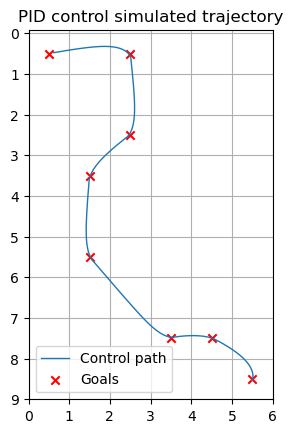

In [58]:
import matplotlib.pyplot as plt
import numpy as np

ax = plt.gca()
ax.invert_yaxis()
ax.set_aspect('equal', adjustable='box')

ct_x = control_x.copy()
ct_y = control_y.copy()

for i in range(len(control_x)):
    ct_x[i] += 0.5
    ct_y[i] += 0.5
    
plt.plot(ct_x, ct_y, linewidth = 1)

x_goals = []
y_goals = []

for goal in goal_list:
    x_goals.append(goal[1]+0.5)
    y_goals.append(goal[0]+0.5)
    
plt.scatter(x_goals, y_goals, color="r", marker="x")

ax.legend(['Control path', 'Goals'])
plt.title("PID control simulated trajectory")

plt.xticks(np.arange(0, 7, step=1))
plt.yticks(np.arange(0, 10, step=1))
plt.grid()

plt.savefig('motion_control.png', dpi=400)
plt.show()